# Data Exploration & Preprocessing
This section loads the dataset, explores its structure, checks for missing values, analyzes class distribution, and prepares features for modeling.

In [1]:
# Load the dataset and show basic info
import pandas as pd
df = pd.read_csv('Network_logs.csv')
df.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal


In [2]:
# Exploratory Data Analysis (EDA)
print('Shape:', df.shape)
print('\nInfo:')
print(df.info())
print('\nMissing values:')
print(df.isnull().sum())
print('\nClass distribution (Intrusion):')
print(df['Intrusion'].value_counts())
print('\nScan_Type distribution:')
print(df['Scan_Type'].value_counts())
print('\nSample value counts for categorical features:')
for col in ['Request_Type', 'Protocol', 'User_Agent', 'Status']:
    print(f'\n{col}:')
    print(df[col].value_counts())

Shape: (8846, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB
None

Missing values:
Source_IP         0
Destination_IP    0
Port              0
Request_Type      0
Protocol          0
Payload_Size      0
User_Agent        0
Status            0
Intrusion         0
Scan_Type         0
dtype: int64

Class distribution (Intrusion):
Intrusion
0    8000


In [6]:
# Data Cleaning & Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# 1. Handling Missing Data
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 2. Handling Outliers (example for Payload_Size)
q1 = df_imputed['Payload_Size'].astype(float).quantile(0.25)
q3 = df_imputed['Payload_Size'].astype(float).quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_imputed = df_imputed[(df_imputed['Payload_Size'].astype(float) >= lower) & (df_imputed['Payload_Size'].astype(float) <= upper)]

# 3. Encoding Categorical Variables
categorical_cols = ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_imputed[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded columns
df_final = pd.concat([df_imputed.drop(columns=categorical_cols).reset_index(drop=True), encoded_df], axis=1)

# 4. Feature Scaling
scaler = StandardScaler()
num_cols = ['Port', 'Payload_Size']
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

df_final.head()

,Source_IP,Destination_IP,Port,Payload_Size,Intrusion,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,...,User_Agent_Nikto/2.1.6,User_Agent_Wget/1.20.3,User_Agent_curl/7.68.0,User_Agent_nmap/7.80,User_Agent_python-requests/2.25.1,Status_Failure,Status_Success,Scan_Type_BotAttack,Scan_Type_Normal,Scan_Type_PortScan
0,192.168.142.55,42.156.67.167,-0.195611,0.882815,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,53.39.165.18,94.60.242.119,-0.181599,-0.053005,1,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,192.168.127.91,7.10.192.3,-0.210641,-0.449576,0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,192.168.30.40,130.169.82.211,-0.209622,-1.030391,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,192.168.43.179,35.140.102.220,-0.210386,1.390607,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [13]:
# Drop non-numeric columns before feature selection
X = df_final.drop('Intrusion', axis=1)
# Keep only numeric columns for modeling
X_numeric = X.select_dtypes(include=[np.number])
y = df_final['Intrusion'].astype(int)

# Wrapper Method: Recursive Feature Elimination (RFE) with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

rfe = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe.fit(X_numeric, y)
selected_features = X_numeric.columns[rfe.support_]
print('RFE selected features:')
print(selected_features)

# Embedded Method: Lasso Regression for feature selection
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_numeric, y)
lasso_selected = X_numeric.columns[lasso.coef_ != 0]
print('Lasso selected features:')
print(lasso_selected)

RFE selected features:
Index(['Port', 'Protocol_UDP', 'User_Agent_curl/7.68.0',
       'User_Agent_nmap/7.80', 'User_Agent_python-requests/2.25.1',
       'Status_Failure', 'Status_Success', 'Scan_Type_BotAttack',
       'Scan_Type_Normal', 'Scan_Type_PortScan'],
      dtype='object')
Lasso selected features:
Index(['Port', 'Scan_Type_Normal'], dtype='object')


In [14]:
# Step 4: Splitting the Data
from sklearn.model_selection import train_test_split, KFold

# Train-Validation-Test Split (60% train, 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_numeric, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}')

# K-Fold Cross-Validation (example: 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_numeric)):
    print(f"Fold {fold+1}: Train indices {train_idx[:5]}, Validation indices {val_idx[:5]}")

Train shape: (5281, 24), Validation shape: (1761, 24), Test shape: (1761, 24)
Fold 1: Train indices [1 2 3 4 5], Validation indices [ 0  8 14 17 19]
Fold 2: Train indices [0 1 2 3 4], Validation indices [15 26 29 31 34]
Fold 3: Train indices [0 1 2 3 4], Validation indices [ 6 12 24 25 30]
Fold 4: Train indices [0 2 3 4 5], Validation indices [ 1  7 11 13 16]
Fold 5: Train indices [0 1 6 7 8], Validation indices [2 3 4 5 9]


In [15]:
# Step 5: Model Selection and Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Baseline Model: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_val_pred = logreg.predict(X_val)
print('Logistic Regression Validation Accuracy:', accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Advanced Model: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)
print('Random Forest Validation Accuracy:', accuracy_score(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

# Hyperparameter Tuning: Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Random Forest Params:', gs.best_params_)
y_val_pred_gs = gs.predict(X_val)
print('Tuned Random Forest Validation Accuracy:', accuracy_score(y_val, y_val_pred_gs))
print(classification_report(y_val, y_val_pred_gs))

Logistic Regression Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Random Forest Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Random Forest Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761
   ma

In [16]:
# Step 1: Define the Problem and Gather Data
# (Already done: Classification problem, KPI = accuracy, precision, recall, F1-score)

# Step 2: Data Preparation and Cleaning
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('Network_logs.csv')
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Outlier removal for Payload_Size
q1 = df_imputed['Payload_Size'].astype(float).quantile(0.25)
q3 = df_imputed['Payload_Size'].astype(float).quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_imputed = df_imputed[(df_imputed['Payload_Size'].astype(float) >= lower) & (df_imputed['Payload_Size'].astype(float) <= upper)]

# Encoding categorical variables
categorical_cols = ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_imputed[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_final = pd.concat([df_imputed.drop(columns=categorical_cols).reset_index(drop=True), encoded_df], axis=1)

# Feature scaling
scaler = StandardScaler()
num_cols = ['Port', 'Payload_Size']
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

# Step 3: Feature Engineering
if 'Intrusion' not in df_final.columns:
    df_final['Intrusion'] = df_imputed['Intrusion'].astype(int).reset_index(drop=True)
df_final['is_web_port'] = df_final['Port'].apply(lambda x: 1 if x in [80, 443] else 0)

# Feature selection (numeric only)
X = df_final.drop('Intrusion', axis=1)
X_numeric = X.select_dtypes(include=[np.number])
y = df_final['Intrusion'].astype(int)

# Step 4: Splitting the Data
from sklearn.model_selection import train_test_split, KFold
X_train, X_temp, y_train, y_temp = train_test_split(X_numeric, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Step 5: Model Selection and Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Baseline model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_val_pred = logreg.predict(X_val)

# Advanced model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
y_val_pred_gs = gs.predict(X_val)

# Step 6: Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

print('Logistic Regression Validation Accuracy:', accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print('Random Forest Validation Accuracy:', accuracy_score(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

print('Tuned Random Forest Validation Accuracy:', accuracy_score(y_val, y_val_pred_gs))
print(classification_report(y_val, y_val_pred_gs))

# Final evaluation on test set
y_test_pred = gs.predict(X_test)
print('Test Set Accuracy:', accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('Test Set ROC-AUC:', roc_auc_score(y_test, y_test_pred))

Logistic Regression Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Random Forest Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Tuned Random Forest Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1761

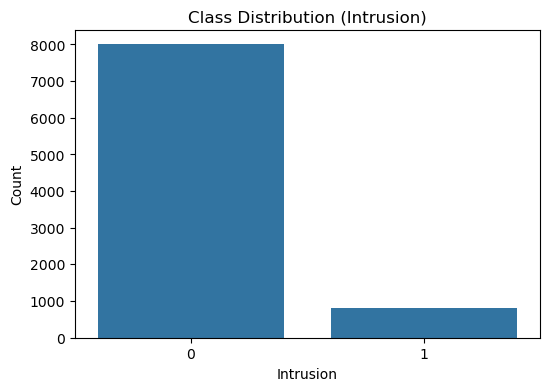

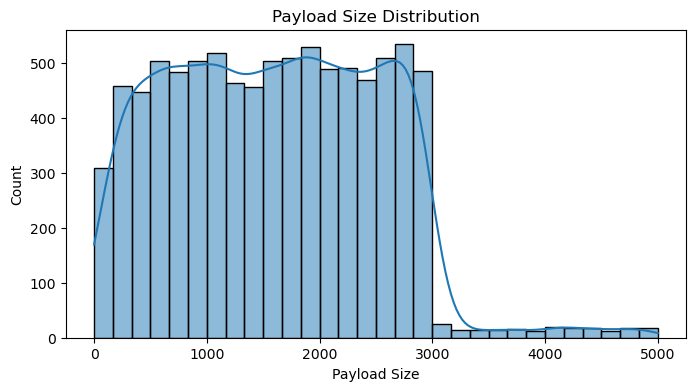

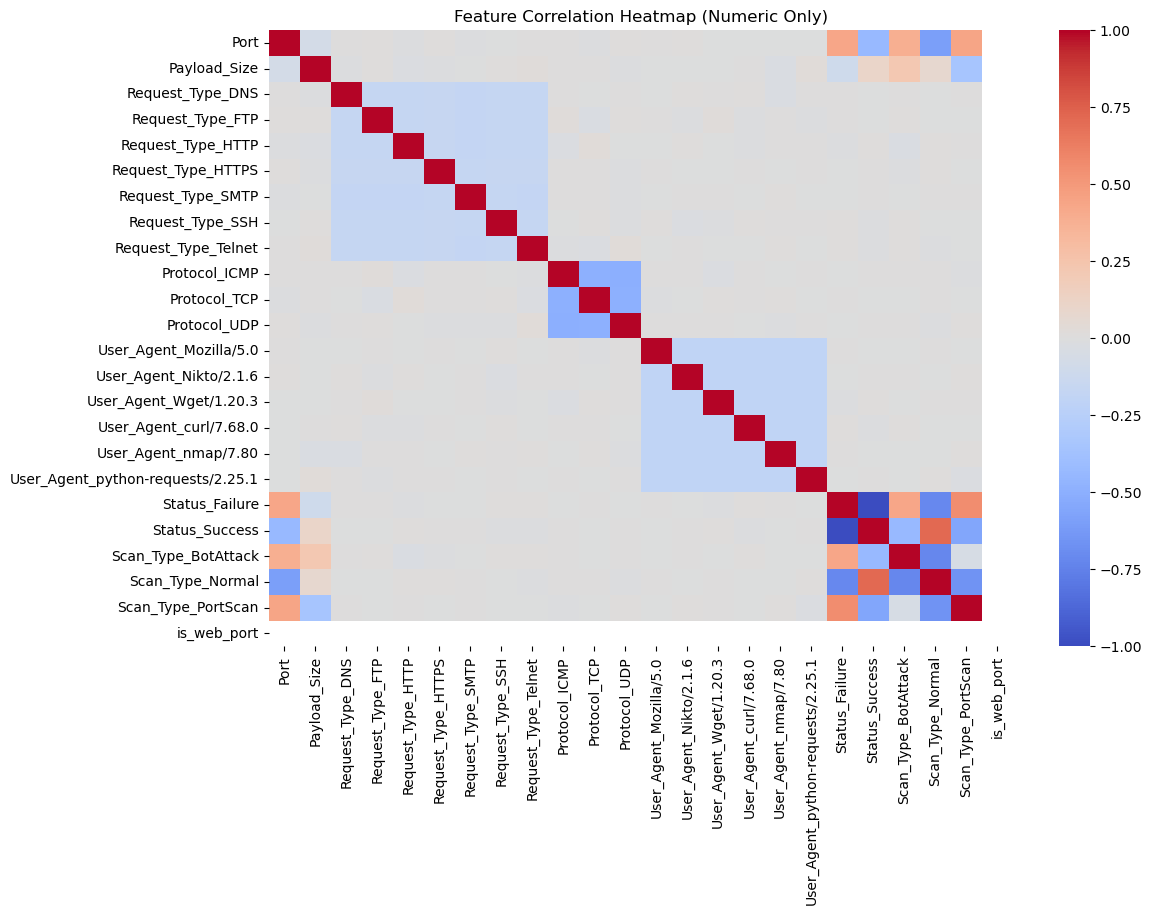

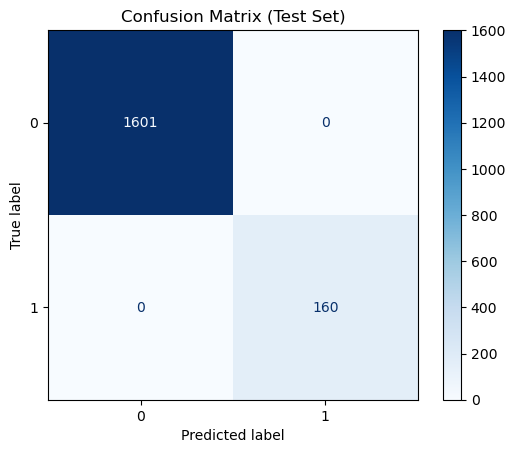

In [19]:
# Visualization Examples
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class balance
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Distribution (Intrusion)')
plt.xlabel('Intrusion')
plt.ylabel('Count')
plt.show()

# 2. Feature distribution (Payload_Size)
plt.figure(figsize=(8,4))
sns.histplot(df['Payload_Size'], bins=30, kde=True)
plt.title('Payload Size Distribution')
plt.xlabel('Payload Size')
plt.show()

# 3. Correlation heatmap (numeric features only)
plt.figure(figsize=(12,8))
corr_matrix = df_final.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Numeric Only)')
plt.show()

# 4. Confusion matrix for best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()